# Autoencoders

An autoencoder encodes the input distribution into a low-dimensional vector that is commonly referred to as the **latent representation or vector or code**. The decoder the decode or reconstruct the latent vector to recover the original input. Since the latent vector is a low-dimensional compressed representation of the input data, the output recovered by the decoder is only an approximation of the input. Given an image, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to the original image. Autoencoders are made up of two parts

$\bullet$ **An encoder network** that compresses the high-dimensional input data into a lower dimensional latent vector. Since the latent vector is of low dimension, the encoder is forced to prioritize which aspects or features of the input should be learn or copied. It often learns useful properties of the data.

$\bullet$ **A decoder network** tries to reconstructe or recover as close as possible the original input data from the latent vector .

An autoencoder whose latent representation  dimension is less than the input dimension is called undercomplete and this forces the autoencoder to capture the most salient features of the training data


 The network is trained to minimize the loss
The Autoencoder network is trained to obtain weights for the encoder and decoder that best minimizes the loss between the original input and the reconstruction of the input after it has passed through the encoder and decoder.
 

x=input data
z=latent vector

$\acute x=$reconstructed image
encoder function $f$

decoder function $g$

$z=f(x)$

$\acute x=g(z)= g(f(x))$

$\acute x \approx x$



$\bullet$ Types of autoencoders based on size of hidden layer

**Undercomplete autoencoders** have hidden layer size smaller than input layer size. Dimension of embedded space or laten representation lower than that of input space

**Overcomplete autoencoders** have much larger hidden layer size. Regularize to avoid overfitting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
plt.rcParams['image.cmap']='gray'

In [2]:

train_data = datasets.FashionMNIST(
    root = './data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    transform = ToTensor()
)

In [3]:
len(train_data)

60000

In [4]:
train_data_loader=DataLoader(train_data,batch_size=100,shuffle=True)
test_data_loader=DataLoader(test_data,batch_size=100,shuffle=True)

In [5]:
for images, labels in train_data_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [6]:
latent_dim = 64

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = nn.Sequential(
                                     nn.Flatten(),
                                     nn.Linear(784,512),
                                     nn.ReLU(),
                                     nn.Linear(512,self.latent_dim),
                                     nn.ReLU()
                                     )
        self.decoder = nn.Sequential(
                                     nn.Linear(self.latent_dim,512),
                                     nn.ReLU(),
                                     nn.Linear(512,784),
                                     nn.Sigmoid()
                                     )

    def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        
        return decoded
    

In [43]:
autoencoder = Autoencoder(latent_dim) 

In [44]:
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(autoencoder.parameters(),lr=0.01)

In [9]:
for epoch in range(10):
    autoencoder.train()
    for x,_ in train_data_loader:
        x=x.view(-1, 28*28)
        output=autoencoder(x)
        train_loss=loss_fn(output,x.reshape(output.shape))
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    autoencoder.eval()
    for x_test,_ in test_data_loader:
        pred=autoencoder(x_test)
        val_loss=loss_fn(pred,x_test.reshape(pred.shape))
    print("Epoch %d: train loss %.3f, val loss %.3f" % (epoch+1, train_loss.detach().numpy().mean(),
                                                        val_loss.detach().numpy().mean()))
    
    

Epoch 1: train loss 0.017, val loss 0.017
Epoch 2: train loss 0.015, val loss 0.014
Epoch 3: train loss 0.014, val loss 0.014
Epoch 4: train loss 0.011, val loss 0.012
Epoch 5: train loss 0.014, val loss 0.013
Epoch 6: train loss 0.013, val loss 0.014
Epoch 7: train loss 0.014, val loss 0.016
Epoch 8: train loss 0.012, val loss 0.013
Epoch 9: train loss 0.011, val loss 0.013
Epoch 10: train loss 0.013, val loss 0.014


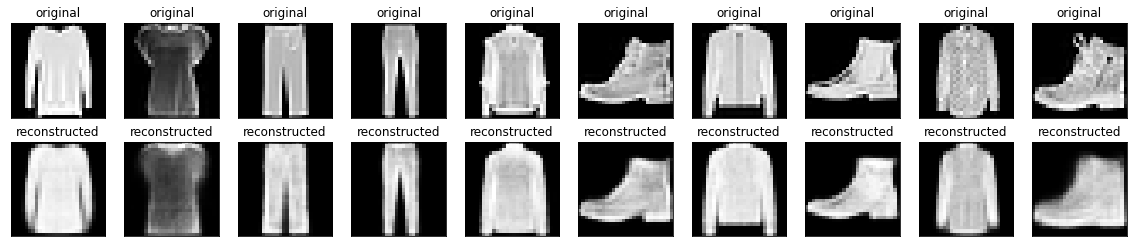

In [10]:
n = 10
image_width = 28

plt.figure(figsize=(20, 4))
orig_imgs = x_test[:n]
decoded_imgs = pred[:n]

for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(orig_imgs[i].detach().view((image_width, image_width)) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(decoded_imgs[i].detach().view((image_width, image_width))   )
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [8]:
class Reshape(nn.Module):
    def __init__(self,*args):
        super().__init__()
        self.shape=args
    def forward(self, x):
        return x.view(self.shape)

class AutoEncoder1(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim=latent_dim
        
        self.encoder = nn.Sequential( Reshape(-1,1,28,28),
                nn.Conv2d(1, 32, kernel_size=3,stride=2, padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 60, kernel_size=3,stride=2, padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(60, 32,  kernel_size=3,stride=2, padding=1),
                nn.Flatten(),
                nn.Linear(512,self.latent_dim),
                                        )
        self.decoder = nn.Sequential( 
                        nn.Linear(self.latent_dim, 512),
                Reshape(-1, 32,4,4),
                nn.ConvTranspose2d(32, 60, kernel_size=3,stride=2, padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(60, 32, kernel_size=4,stride=2,padding=1)   ,             
                nn.LeakyReLU(0.01),
               
                nn.ConvTranspose2d( 32,1, kernel_size=4,stride=2, padding=1),                
                nn.Sigmoid()
                
                )

    def forward(self, x):
        latent_vector  = self.encoder(x)
        output = self.decoder(latent_vector)
        return output
autoencoder2=AutoEncoder1(latent_dim=latent_dim)

In [11]:
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(autoencoder2.parameters())

In [12]:
for epoch in range(10):
    autoencoder2.train()
    for x,_ in train_data_loader:
        output=autoencoder2(x)
        train_loss=loss_fn(output,x.reshape(output.shape))
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    autoencoder2.eval()
    for x_test,_ in test_data_loader:
        pred_con=autoencoder2(x_test)
        val_loss=loss_fn(pred_con,x_test.reshape(pred_con.shape))
    print("Epoch %d: train loss %.3f, val loss %.3f" % (epoch+1, train_loss.detach().numpy().mean(),
                                                        val_loss.detach().numpy().mean()))
    
    

Epoch 1: train loss 0.008, val loss 0.010
Epoch 2: train loss 0.008, val loss 0.008
Epoch 3: train loss 0.008, val loss 0.009
Epoch 4: train loss 0.007, val loss 0.007
Epoch 5: train loss 0.006, val loss 0.007
Epoch 6: train loss 0.007, val loss 0.006
Epoch 7: train loss 0.007, val loss 0.005
Epoch 8: train loss 0.007, val loss 0.005
Epoch 9: train loss 0.006, val loss 0.007
Epoch 10: train loss 0.006, val loss 0.006


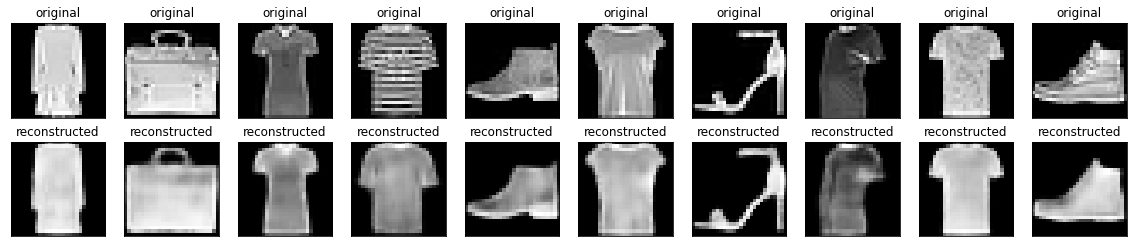

In [13]:
n = 10
image_width = 28

plt.figure(figsize=(20, 4))
orig_imgs = x_test[:n]
decoded_imgs = pred_con[:n]

for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(orig_imgs[i].detach().view((image_width, image_width)) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(decoded_imgs[i].detach().view((image_width, image_width))   )
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()